# **PINN Method**

# **Import required libraries**

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# **Define the PINN Model Architecture**

In [ ]:
# Define the PINN model with a modified architecture
def create_model():
    model = keras.Sequential([
        layers.Input(shape=(1,)),  # Input layer
        layers.Dense(128, activation='relu'),  # Hidden layer 1 with more neurons
        layers.Dense(128, activation='relu'),  # Hidden layer 2 with more neurons
        layers.Dense(64, activation='relu'),   # Additional hidden layer
        layers.Dense(4)  # Output layer for T, TA, TL, and V
    ])
    return model

# **Define the Loss Function**

In [ ]:
# Define the loss function for PINN
def pinn_loss(y_true, y_pred):
    mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))  # MSE loss
    return mse_loss


# **Generate Training Data**

In [ ]:
def generate_training_data(s, r, Tmax, mu, k1, k2, beta, alpha, N, dt, time_steps):
    T = np.zeros(time_steps)
    TA = np.zeros(time_steps)
    TL = np.zeros(time_steps)
    V = np.zeros(time_steps)

    T[0], TA[0], TL[0], V[0] = 1000, 0, 0, 0.001  # Reduced initial concentrations

    for i in range(1, time_steps):
        dT = s + r * T[i - 1] * (1 - (T[i - 1] + TA[i - 1] + TL[i - 1]) / Tmax) - mu * T[i - 1] - k1 * V[i - 1] * T[i - 1]
        dTA = k1 * V[i - 1] * T[i - 1] - mu * TA[i - 1] - k2 * TL[i - 1]
        dTL = k2 * TL[i - 1] - beta * TA[i - 1]
        dV = N * beta * TA[i - 1] - k1 * V[i - 1] * T[i - 1] - alpha * V[i - 1]

        T[i] = T[i - 1] + dT * dt
        TA[i] = TA[i - 1] + dTA * dt
        TL[i] = TL[i - 1] + dTL * dt
        V[i] = V[i - 1] + dV * dt

    time = np.arange(0, time_steps * dt, dt)
    return time, T, TA, TL, V


# **Initialize the Parameters**

In [ ]:
# Parameters for the differential equations
s = 10
r = 0.03
Tmax = 1500
mu = 0.02
k1 = 0.000024
k2 = 0.003
beta = 0.24
alpha = 2.4
N = 1400

# Time parameters
dt = 0.1  # Time step
time_steps = 130  # Number of time steps


# **Generate and Normalize Training Data**

In [ ]:
# Generate training data
time, T, TA, TL, V = generate_training_data(s, r, Tmax, mu, k1, k2, beta, alpha, N, dt, time_steps)

# Normalize the training data
time_mean, time_std = time.mean(), time.std()
T_mean, T_std = T.mean(), T.std()
TA_mean, TA_std = TA.mean(), TA.std()
TL_mean, TL_std = TL.mean(), TL.std()
V_mean, V_std = V.mean(), V.std()

time = (time - time_mean) / time_std
T = (T - T_mean) / T_std
TA = (TA - TA_mean) / TA_std
TL = (TL - TL_mean) / TL_std
V = (V - V_mean) / V_std


# **Define the Model and Compile**

In [ ]:
# Define the PINN model
model = create_model()

# Compile the model with a lower learning rate
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), loss=pinn_loss)


# **Train the Model**

In [ ]:
# Train the model for more epochs
x_train = time.reshape(-1, 1)
y_train = np.column_stack((T, TA, TL, V))
model.fit(x_train, y_train, epochs=2000, verbose=1)


# **Make Predictions and Denormalize**

In [ ]:
# Predict using the trained model
predictions = model.predict(x_train)

# Denormalize the predictions
predictions = predictions * np.array([T_std, TA_std, TL_std, V_std]) + np.array([T_mean, TA_mean, TL_mean, V_mean])


# **Visualization**

In [ ]:
# Plot the concentrations over time
plt.figure(figsize=(10, 6))
plt.plot(time * time_std + time_mean, T * T_std + T_mean, label='T')
plt.plot(time * time_std + time_mean, TA * TA_std + TA_mean, label='TA')
plt.plot(time * time_std + time_mean, TL * TL_std + TL_mean, label='TL')
plt.plot(time * time_std + time_mean, V * V_std + V_mean, label='V')
plt.plot(time * time_std + time_mean, predictions[:, 0], label='Predicted T')
plt.plot(time * time_std + time_mean, predictions[:, 1], label='Predicted TA')
plt.plot(time * time_std + time_mean, predictions[:, 2], label='Predicted TL')
plt.plot(time * time_std + time_mean, predictions[:, 3], label='Predicted V')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.title('Concentration vs Time')
plt.legend()
plt.grid(True)
plt.show()


# **Visualization of T-cell Interactions**

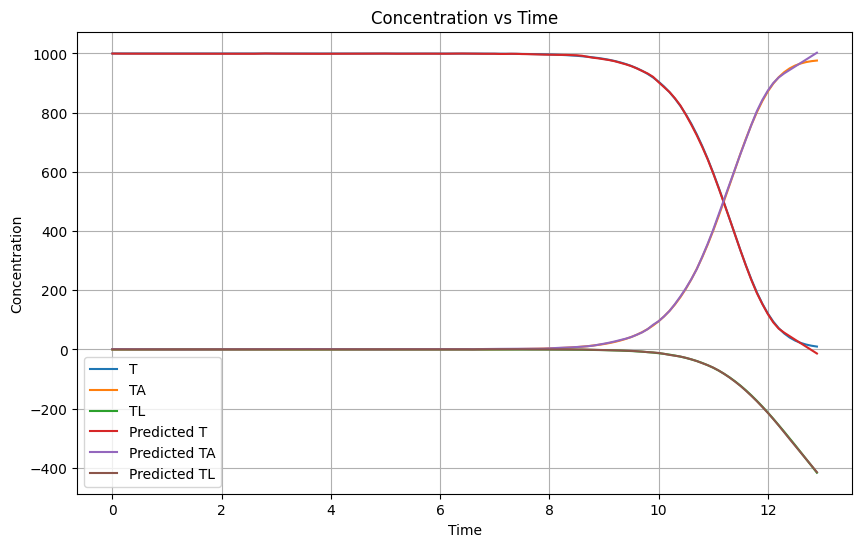

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(time * time_std + time_mean, T * T_std + T_mean, label='T')
plt.plot(time * time_std + time_mean, TA * TA_std + TA_mean, label='TA')
plt.plot(time * time_std + time_mean, TL * TL_std + TL_mean, label='TL')
#plt.plot(time * time_std + time_mean, V * V_std + V_mean, label='V')
plt.plot(time * time_std + time_mean, predictions[:, 0], label='Predicted T')
plt.plot(time * time_std + time_mean, predictions[:, 1], label='Predicted TA')
plt.plot(time * time_std + time_mean, predictions[:, 2], label='Predicted TL')
#plt.plot(time * time_std + time_mean, predictions[:, 3], label='Predicted V')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.title('Concentration vs Time')
plt.legend()
plt.grid(True)
plt.show()

# **Visualization of T-cell Interactions**

In [ ]:
plt.plot(time, T, label='T')
plt.plot(time, TA, label='TA')
plt.plot(time, TL, label='TL')
#plt.plot(time, V, label='V')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.legend()
plt.show()